In [1]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

COLOR = plt.cm.hot

DIMS = (16, 16)
NF = 2 # number of features / parameters

In [2]:
from functions import ackley, easom, himmelblau, holder_table, rastrigin

function_plot = np.zeros((512, 512), dtype=float)

x = np.zeros(2)

i_space = np.linspace(-5.12, 5.12, 512)
j_space = np.linspace(-5.12, 5.12, 512)

for i, xi in enumerate(i_space):
    for j, xj in enumerate(j_space):
        x[0], x[1] = xi, xj
        function_plot[i][j] = rastrigin(x)

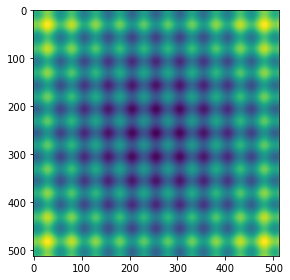

In [3]:
function_plot /= np.max(function_plot)
# image = Image.fromarray(np.uint8(COLOR(function_plot) * 255))
plt.imshow(function_plot)
plt.tight_layout()
plt.show()

In [4]:
def sample_uniform(low, high, shape):
    return np.random.uniform(low, high, shape)


def evaluate(population, f=rastrigin):
    return 1.0 / (np.apply_along_axis(f, 2, population) + 1.0)


def plot_fitness(fitness):
    plt.imshow(fitness)
    plt.tight_layout()
    plt.show()

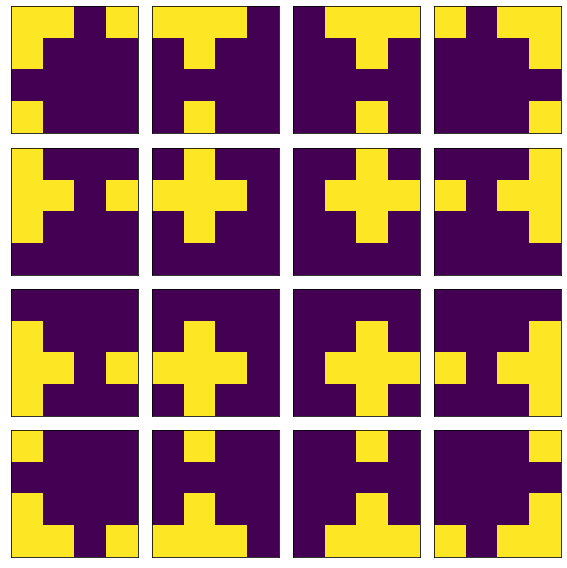

In [5]:
from operators import nhood_linear

def draw_nhood(image, nhood_idx):
    for idx in nhood_idx:
        x, y = idx
        image[x][y] = 1.0


fig, ax = plt.subplots(4, 4, figsize=(8, 8), subplot_kw={"xticks": (), "yticks": ()})

for i in range(4):
    for j in range(4):
        image = np.zeros((4, 4))
        nhood_idx = nhood_linear(i, j, (4, 4))
        draw_nhood(image, nhood_idx)
        ax[i][j].imshow(image)
fig.tight_layout()

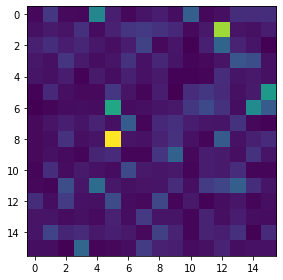

In [6]:
pop = sample_uniform(-5.00, 5.00, DIMS + (NF,))
fit = evaluate(pop)
fit_plot = fit / np.max(fit)
# fit_plot = np.uint8(COLOR(fit_plot) * 255)
plot_fitness(fit_plot)

In [7]:
import time

from operators import mutate_gaussian
from operators import nhood_get, nhood_set
from operators import recomb_singlepoint
from operators import replace_always
from operators import select_linear, select_roulette

# n_steps = 1
# x_range = range(1)
# y_range = range(1)

n_steps = 50
x_range = range(DIMS[0])
y_range = range(DIMS[1])

pb_mutate = 0.1

metrics = {
    "min": np.zeros(n_steps),
    "max": np.zeros(n_steps),
    "avg": np.zeros(n_steps)
}

history = np.zeros((n_steps,) + DIMS)

for step in range(n_steps):
    start = time.time()
    pop_new = np.zeros_like(pop)
    
    for x in x_range:
        for y in y_range:
            nhood_idx        = list(nhood_linear(x, y, DIMS))
            nhood, nhood_fit = nhood_get(pop, fit, nhood_idx)

            a, b = select_linear(nhood, nhood_fit)
            # a = select_roulette(nhood, nhood_fit)
            c = recomb_singlepoint(nhood[a], nhood[b])
            p = np.random.random()
            if p < pb_mutate: c = np.clip(mutate_gaussian(c, sigma=0.01), -5.12, 5.12)
            pop_new[x][y] = c

    pop[:] = pop_new
    fit = evaluate(pop)
    history[step] = fit
    metrics["min"][step] = np.min(fit)
    metrics["max"][step] = np.max(fit)
    metrics["avg"][step] = np.mean(fit)   
    if (step + 1) % 10 == 0:
        end = time.time()
        print("step ({:3}) - {:.4f}s elapsed".format(step + 1, end - start))


step ( 10) - 0.0359s elapsed
step ( 20) - 0.0368s elapsed
step ( 30) - 0.0428s elapsed
step ( 40) - 0.0395s elapsed
step ( 50) - 0.0382s elapsed


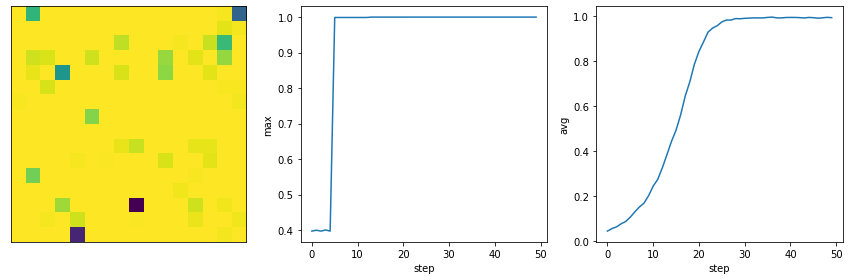

In [8]:
step_range = range(n_steps)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_yticks([])
ax[0].set_xticks([])
fit_plot = fit / np.max(fit)
# fit_plot = np.uint8(COLOR(fit_plot) * 255)
ax[0].imshow(fit_plot)
ax[1].set_xlabel("step")
ax[1].set_ylabel("max")
ax[1].plot(step_range, metrics["max"])
ax[2].set_xlabel("step")
ax[2].set_ylabel("avg")
ax[2].plot(step_range, metrics["avg"])
fig.tight_layout()

In [9]:
# for frame in history:
#     frame /= np.max(frame)
frames = [Image.fromarray(frame * 255) for frame in history]
frames[0].save("cea.gif", save_all=True, append_images=frames[1:], duration=200, loop=0)